# 시작

In [23]:
import os, glob, math
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import dlib, cv2

LFW_PATH = os.getenv('HOME') + '/lfw'
DATA_PATH = os.getenv('HOME') + '/aiffel/coarse_to_fine/lfw_data'
TRAIN_IMAGE_PATH = os.path.join(DATA_PATH, 'train', 'input')
TRAIN_LABEL_PATH = os.path.join(DATA_PATH, 'train', 'label')
VALID_IMAGE_PATH = os.path.join(DATA_PATH, 'val', 'input')
VALID_LABEL_PATH = os.path.join(DATA_PATH, 'val', 'label')

IMAGE_SHAPE = (80, 120)

# MEAN-SHIFT를 이용하여 데이터 추출

In [27]:
def search_face_files(directory):
    files = []
    for file in os.listdir(directory):
        current = os.path.join(directory, file)
        if os.path.isdir(current):
            files.extend(search_face_files(current))
        else:
            ext = os.path.splitext(current)[-1]
            if ext == '.jpg' or ext == '.png':
                files.append(current)
    return files

def eye_crop(image, landmark):
    # dlib eye landmark: 36~41 (6), 42~47 (6)
    left_eye_points = np.array(landmark[36:42])
    right_eye_points = np.array(landmark[42:48])

    left_top_left = left_eye_points.min(axis=0)
    left_bottom_right = left_eye_points.max(axis=0)
    right_top_left = right_eye_points.min(axis=0)
    right_bottom_right = right_eye_points.max(axis=0)

    left_eye_size = left_bottom_right - left_top_left
    right_eye_size = right_bottom_right - right_top_left

    ### if eye size is small
    if left_eye_size[1] < 5:
        margin = 1
    else:
        margin = 2

    img_left_eye = image[left_top_left[1] - margin:left_bottom_right[1] + margin,
                   left_top_left[0] - margin:left_bottom_right[0] + margin]
    img_right_eye = image[right_top_left[1] - margin:right_bottom_right[1] + margin,
                    right_top_left[0] - margin:right_bottom_right[0] + margin]

    return [img_left_eye, img_right_eye]


# 눈 이미지에서 중심을 찾는 함수
def findCenterPoint(gray_eye, str_direction='left'):
    filtered_eye = cv2.bilateralFilter(gray_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)

    # 2D images -> 1D signals
    row_sum = 255 - np.sum(filtered_eye, axis=0) // gray_eye.shape[0]
    col_sum = 255 - np.sum(filtered_eye, axis=1) // gray_eye.shape[1]

    # normalization & stabilization
    def vector_normalization(vector):
        vector = vector.astype(np.float32)
        vector = (vector - vector.min()) / (vector.max() - vector.min() + 1e-6) * 255
        vector = vector.astype(np.uint8)
        vector = cv2.blur(vector, (5, 1)).reshape((vector.shape[0],))
        vector = cv2.blur(vector, (5, 1)).reshape((vector.shape[0],))
        return vector

    row_sum = vector_normalization(row_sum)
    col_sum = vector_normalization(col_sum)

    def findOptimalCenter(gray_eye, vector, str_axis='x'):
        axis = 1 if str_axis == 'x' else 0
        center_from_start = np.argmax(vector)
        center_from_end = gray_eye.shape[axis] - 1 - np.argmax(np.flip(vector, axis=0))
        return (center_from_end + center_from_start) // 2


    # x 축 center 를 찾는 알고리즘을 mean shift 로 대체합니다.
    # center_x = findOptimalCenter(gray_eye, row_sum, 'x')
    center_y = findOptimalCenter(gray_eye, col_sum, 'y')

    # 수정된 부분
    inv_eye = (255 - filtered_eye).astype(np.float32)
    inv_eye = (255 * (inv_eye - inv_eye.min()) / (inv_eye.max() - inv_eye.min())).astype(np.uint8)

    resized_inv_eye = cv2.resize(inv_eye, (inv_eye.shape[1] // 3, inv_eye.shape[0] // 3))
    init_point = np.unravel_index(np.argmax(resized_inv_eye), resized_inv_eye.shape)

    x_candidate = init_point[1] * 3 + 1
    for idx in range(10):
        temp_sum = row_sum[x_candidate - 2:x_candidate + 3].sum()
        if temp_sum == 0:
            break
        normalized_row_sum_part = row_sum[x_candidate - 2:x_candidate + 3].astype(np.float32) // temp_sum
        moving_factor = normalized_row_sum_part[3:5].sum() - normalized_row_sum_part[0:2].sum()
        if moving_factor > 0.0:
            x_candidate += 1
        elif moving_factor < 0.0:
            x_candidate -= 1

    center_x = x_candidate

    if center_x >= gray_eye.shape[1] - 2 or center_x <= 2:
        center_x = -1
    elif center_y >= gray_eye.shape[0] - 1 or center_y <= 1:
        center_y = -1

    return [center_x, center_y]

# 눈동자 검출 wrapper 함수
def detectPupil(left_eye, right_eye):
    gray_left_eye = cv2.cvtColor(left_eye, cv2.COLOR_BGR2GRAY)
    gray_right_eye = cv2.cvtColor(right_eye, cv2.COLOR_BGR2GRAY)

    left_center_x, left_center_y = findCenterPoint(gray_left_eye, 'left')
    right_center_x, right_center_y = findCenterPoint(gray_right_eye, 'right')

    return left_center_x, left_center_y, right_center_x, right_center_y

In [30]:
def crop_eyes_from_files(files):
    detector_hog = dlib.get_frontal_face_detector()  # detector 선언
    landmark_file = os.getenv('HOME') + '/aiffel/coarse_to_fine/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(landmark_file)

    for idx, img_file in enumerate(files):
        img = cv2.imread(img_file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if idx % 10 == 0:  # for validation
            input_dir = os.path.join(VALID_IMAGE_PATH, 'img')
            label_dir = os.path.join(VALID_LABEL_PATH, 'mask')
        else:    # for train
            input_dir = os.path.join(TRAIN_IMAGE_PATH, 'img')
            label_dir = os.path.join(TRAIN_LABEL_PATH, 'mask')

        left_eye_img_path = os.path.join(input_dir, ('eye_%06d_l.png' % idx))
        right_eye_img_path = os.path.join(input_dir, ('eye_%06d_r.png' % idx))
        left_eye_label_path = os.path.join(label_dir, ('eye_%06d_l.png' % idx))
        right_eye_label_path = os.path.join(label_dir, ('eye_%06d_r.png' % idx))

        dlib_rects = detector_hog(img_rgb, 1)  # (image, num of img pyramid)

        list_landmarks = []
        for dlib_rect in dlib_rects:
            points = landmark_predictor(img_rgb, dlib_rect)
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            list_landmarks.append(list_points)
        if not list_landmarks:
            continue
        landmark = list_landmarks[0]

        # 눈 이미지 crop
        img_left_eye, img_right_eye = eye_crop(img, landmark)
        if not np.any(img_left_eye) or not np.any(img_right_eye):
            continue
        # 눈동자 중심 좌표 출력
        left_center_x, left_center_y, right_center_x, right_center_y = detectPupil(img_left_eye, img_right_eye)

        left_left_x = landmark[36][0]
        left_left_y = landmark[36][1]
        left_right_x = landmark[39][0]
        left_right_y = landmark[39][1]
        right_left_x = landmark[42][0]
        right_left_y = landmark[42][1]
        right_right_x = landmark[45][0]
        right_right_y = landmark[45][1]

        # left eye 이미지 출력
        cv2.imwrite(left_eye_img_path, img_left_eye)

        img_label_left = cv2.circle(np.zeros_like(img_left_eye), (left_left_x, left_left_y), 3, (1), -1) 
        img_label_left = cv2.circle(img_label_left, (left_right_x, left_right_y), 3, (2), -1) 
        img_label_left = cv2.circle(img_label_left, (left_center_x, left_center_y), 3, (3), -1) 
        cv2.imwrite(left_eye_label_path, img_label_left)

        # right eye 이미지 출력
        cv2.imwrite(right_eye_img_path, img_right_eye)

        img_label_right = cv2.circle(np.zeros_like(img_right_eye), (right_left_x, right_left_y), 3, (1), -1)
        img_label_right = cv2.circle(img_label_right, (right_right_x, right_right_y), 3, (2), -1)
        img_label_right = cv2.circle(img_label_right, (right_center_x, right_center_y), 3, (3), -1)
        cv2.imwrite(right_eye_label_path, img_label_right)

        if idx % 1000 == 0:
            print('%d image OK..' % idx)

    print('Finished!!')


# 데이터 생성기

In [4]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

# 모델 훈련

In [35]:
def lr_step_decay(epoch):
    init_lr = 0.0005 #self.flag.initial_learning_rate
    lr_decay = 0.5 #self.flag.learning_rate_decay_factor
    epoch_per_decay = 2 #self.flag.epoch_per_decay
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
    return lrate

# 메인

## 원본 lfw데이터로부터 데이터를 정제

In [31]:
files = search_face_files(LFW_PATH)
crop_eyes_from_files(files)

0 image OK..
1000 image OK..
2000 image OK..
3000 image OK..
4000 image OK..
5000 image OK..
6000 image OK..
7000 image OK..
8000 image OK..
9000 image OK..
10000 image OK..
11000 image OK..
12000 image OK..
13000 image OK..
Finished!!


## 정제된 데이터 연결

In [33]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(IMAGE_PATH, class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(LABEL_PATH, class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
user_train_generator = user_generation(image_data, label_data)

Found 23712 images belonging to 1 classes.
Found 23712 images belonging to 1 classes.


## 모델 준비 & 훈련

In [34]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(80,120,3))
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(6, activation='sigmoid')
])
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
learning_rate = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)
history = model.fit(
    user_train_generator,
    epochs=10,
    steps_per_epoch=image_data.samples//image_data.batch_size,
    callbacks = [learning_rate]
)

23712 32 741
Epoch 1/10


/home/ssac5/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac5/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ssac5/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


741/741 [==============================] - 111s 150ms/step - loss: 0.0197 - mae: 0.0687
Epoch 2/10
741/741 [==============================] - 111s 149ms/step - loss: 0.0144 - mae: 0.0561
Epoch 3/10
741/741 [==============================] - 112s 152ms/step - loss: 0.0137 - mae: 0.0544
Epoch 4/10
741/741 [==============================] - 112s 151ms/step - loss: 0.0133 - mae: 0.0534
Epoch 5/10
741/741 [==============================] - 111s 149ms/step - loss: 0.0131 - mae: 0.0528
Epoch 6/10
741/741 [==============================] - 111s 150ms/step - loss: 0.0130 - mae: 0.0525
Epoch 7/10
741/741 [==============================] - 111s 150ms/step - loss: 0.0129 - mae: 0.0522
Epoch 8/10
741/741 [==============================] - 114s 153ms/step - loss: 0.0129 - mae: 0.0521
Epoch 9/10
741/741 [==============================] - 112s 152ms/step - loss: 0.0128 - mae: 0.0520
Epoch 10/10
741/741 [==============================] - 112s 152ms/step - loss: 0.0128 - mae: 0.0519


dict_keys(['loss', 'mae', 'lr'])


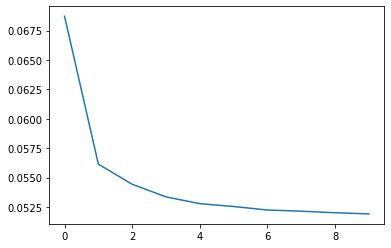

In [17]:
plt.plot(history.history['mae'])

# 결론

dlib로부터 추출한 대략의 위치를 추정한 데이터를 가지고 학습을 시킨다면 모델이 제대로 학습될 수 없다.(dlib를 뛰어 넘을 수 없다)   
이점은 mean_shift를 포함하여 모든 수학적인 방법을 동원해도 달라지지 않는다.   
그러므로 데이터를 아무리 늘린다고 하여도 좋은 결과를 내놓는 모델을 만들 수 없다.   
필요한 작업은 dlib를 이용하여 얻은 대략의 위치를 사람이 다시 재조정하는 일이다.   
수작업으로 데이터를 하나하나 정제해야 좋은 모델을 학습시킬 수 있다.

위 작업을 했다고 가정하고 좋은 모델을 얻었다고 가정한다고 하여도, 이 모델이 할 수 있는 작업은 ('눈' 그림, 눈동자의 위치)쌍을 얻어내는 것이다.   
하지만 놀라는 눈을 붙이기 위해서는 '사람' 그림에서 눈동자 위치를 알아내는 작업이 필요하다.   
결국 '사람'그림에서 '눈'위치를 얻은 후 모델에 입력하여야 할텐데, '사람'그림에서 '눈'위치를 얻기 위해서는 다시 dlib를 사용해야 한다.   
따라서 딥러닝 모델만 가지고 놀라는 눈을 붙일 수 없게 된다.

모델만 이용하여 놀라는 눈을 붙이고 싶다면, 처음부터 ('사람'그림, 눈동자의 위치) 데이터를 가지고 모델을 학습시켜야 하고, 첫 단계부터 다시 수행되어야 한다.